In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path

import matplotlib.pyplot as plt
import os
import logging

from tqdm import tqdm
from unet import UNet
import wandb

###

import importlib
import evaluate
import utils.unet_preprocessing
import utils.dice_score
import utils.dataset


importlib.reload(evaluate)
importlib.reload(utils.unet_preprocessing)
importlib.reload(utils.dice_score)
importlib.reload(utils.dataset)

###

from utils.parse_arguments import parse_arguments
from utils.dataset import DataSet, SLICES
from utils.unet_preprocessing import convert_labels_to_gaussian_masks, convert_labels_to_radial_masks, convert_labels_to_single_mask
from utils.dice_score import dice_loss, tversky_loss
from evaluate import evaluate

from utils.models.RegressionCNN import *
from utils.models.Resnet import *

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
# os.environ["WANDB_API_KEY"] = "10e87cba232280915175bb4d315f2ed375a9ae8d"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
logging.info(f'Using device {device}')

INFO: Using device cuda:1


In [2]:
data_path = './data/standard_labels/train'
val_data_path = './data/standard_labels/val'

checkpoint_path = Path('./checkpoints/')
save_checkpoint = True

random_seed = 42
results_path = './model_tests'
no_midpoint = True
test_name_prefix = ""
filter_level = 0
record_spread = False

batch_size = 8
num_epochs = 600
num_features = 8
relu = False
dropout = 0.5
early_stopping_patience = 20

lr = 1e-6
weight_decay = 1e-8
momentum = 0.999
bilinear = False
sigma = 5

rotation = 10 # degree
translation = 0.1  # % of image shift
scale = 1.5 
contrast = 1.0
flipping = False

amp = False
CE = 0.95
tversky_beta = -1

In [3]:
# checkpoint_path = Path('./checkpoints/')

# data_path, val_data_path, random_seed, results_path, no_midpoint, test_name_prefix, filter_level, record_spread, \
#         batch_size, num_epochs, num_features, relu, dropout, early_stopping_patience, \
#             lr, weight_decay, momentum, bilinear, sigma, CE, tversky_beta, amp, save_checkpoint, \
#                 rotation, translation, scale, contrast, flipping = parse_arguments()

In [3]:
torch.manual_seed(random_seed)

TEST_NAME = f"lr_{lr}_wd_{weight_decay}_m_{momentum}_b_{bilinear}_mid_{no_midpoint}_s_{sigma}"
print(TEST_NAME)
    
train_dataset = DataSet(data_path, degrees=rotation, translate=translation, scale=scale, contrast=contrast, flipping=flipping, no_midpoint=no_midpoint, filter_level=filter_level)
val_dataset = DataSet(val_data_path, no_midpoint=no_midpoint, filter_level=filter_level)
n_train, n_val = len(train_dataset), len(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

lr_1e-06_wd_1e-08_m_0.999_b_False_mid_True_s_5


In [4]:
# extra class for background
unet = UNet(n_channels=1, n_classes=3 if no_midpoint else 4, bilinear=bilinear)
unet = unet.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.RMSprop(unet.parameters(),
            lr=lr, weight_decay=weight_decay, momentum=momentum, foreach=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if unet.n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0

In [9]:
experiment = wandb.init(project='U-Net-test_unet', resume='allow', anonymous='allow')
experiment.config.update(
    dict(epochs=num_epochs, batch_size=batch_size, learning_rate=lr)
)

logging.info(f'''Starting training:
    Epochs:          {num_epochs}
    Batch size:      {batch_size}
    Learning rate:   {lr}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_checkpoint}
    Device:          {device.type}
    Mixed Precision: {amp}

    CE: {CE}
    Sigma: {sigma}
    Tversky beta: {tversky_beta}
    Filter level: {filter_level}

    Rotation: {rotation}
    Translation: {translation}
    Scale: {scale}
    Contrast: {contrast}
''')

INFO: Starting training:
    Epochs:          600
    Batch size:      8
    Learning rate:   1e-06
    Training size:   384
    Validation size: 53
    Checkpoints:     True
    Device:          cuda
    Mixed Precision: False

    CE: 0.95
    Sigma: 5
    Tversky beta: -1
    Filter level: 0

    Rotation: 10
    Translation: 0.1
    Scale: 1.5
    Contrast: 1.0



In [10]:
# convert_labels_to_single_mask (radial)

# model output is multiple segments
# the "true_masks" are a single mask, containing indices respect to each segmentation

highest_validation = 0
for epoch in range(1, num_epochs + 1):
        unet.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{num_epochs}', unit='img') as pbar:
            for images, _, labels in train_dataloader:
                images = images[:, None, :, :] # to match input channels
                true_masks = convert_labels_to_single_mask(labels, 200, 200, sigma) # radius

                assert images.shape[1] == unet.n_channels, \
                    f'Network has been defined with {unet.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'
                
                # print(images.size())
                # plt.imshow(images[0][0].cpu(), cmap='gray')
                # plt.show()

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = unet(images)
                    if unet.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = CE * criterion(masks_pred, true_masks)

                        # Only tversky/dice on non-background classes
                        if 0 < tversky_beta < 1:
                            loss += (1 - CE) * tversky_loss(
                                F.softmax(masks_pred, dim=1)[:, 1:].float(),
                                F.one_hot(true_masks, unet.n_classes).permute(0, 3, 1, 2)[:, 1:].float(),
                                multiclass=True,
                                alpha=(1-tversky_beta),
                                beta=tversky_beta
                            )
                        else:
                            loss += (1 - CE) * dice_loss(
                                F.softmax(masks_pred, dim=1)[:, 1:].float(),
                                F.one_hot(true_masks, unet.n_classes).permute(0, 3, 1, 2)[:, 1:].float(),
                                multiclass=True
                            )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (20 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in unet.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(unet, val_dataloader, device, amp, sigma)
                        scheduler.step(val_score)

                        highest_validation = max(highest_validation, val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:


                            # background always still main feature :(
                            # print(masks_pred.argmax(dim=1).size())
                            # plt.imshow(masks_pred.argmax(dim=1)[7].cpu(), cmap='gray')
                            # plt.show()
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        
        if save_checkpoint:
            Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
            state_dict = unet.state_dict()
            torch.save(state_dict, str(checkpoint_path / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')

    

Epoch 1/600:   2%|▏         | 8/384 [00:00<00:44,  8.42img/s, loss (batch)=0.917]


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
exit()

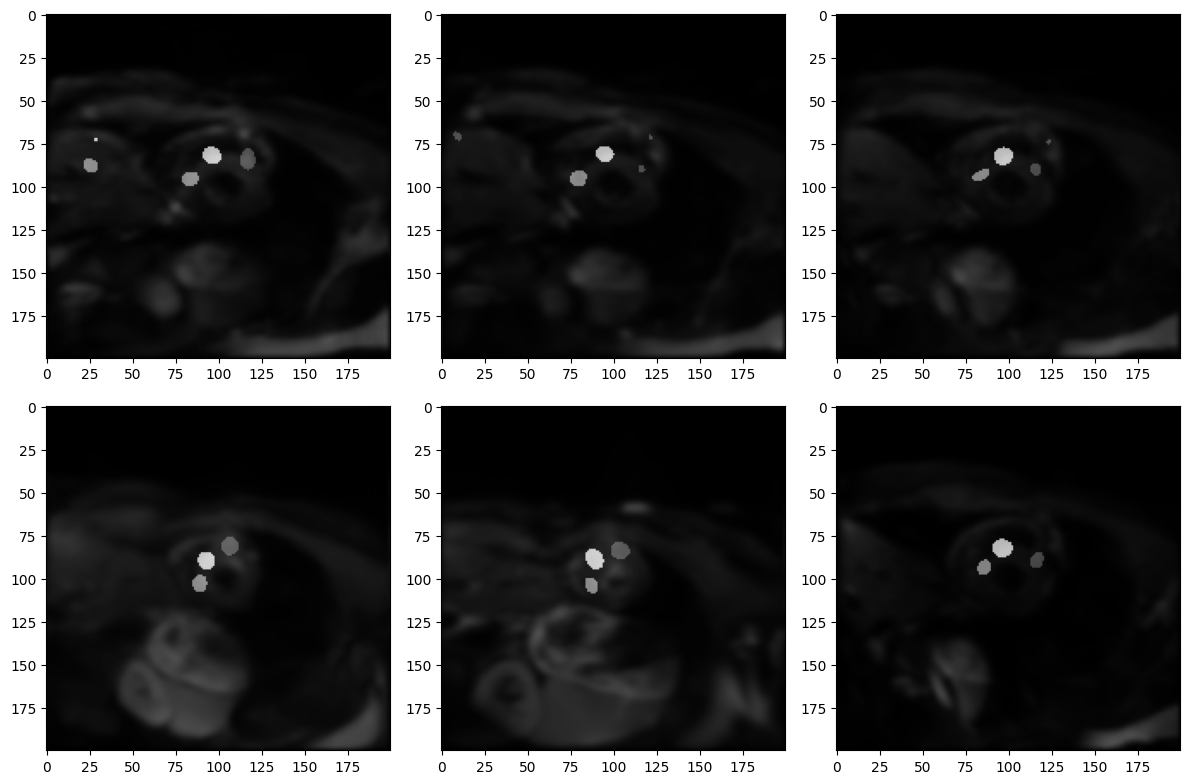

In [ ]:

unet = UNet(n_channels=1, n_classes=3 if no_midpoint else 4, bilinear=bilinear)

unet.to(device=device)
state_dict = torch.load('checkpoints/checkpoint_epoch600.pth', map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
unet.load_state_dict(state_dict)

inv_SLICES = {v: k for k, v in SLICES.items()}
fig, axes = plt.subplots(2,3, figsize=(12,8),dpi=100)

val_loss = 0.0
with torch.no_grad():
    for i, (images, _, labels) in enumerate(val_dataloader):

        images = images[:, None, :, :]
        true_masks = convert_labels_to_single_mask(labels, 200, 200, sigma)

        images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        true_masks = true_masks.to(device=device, dtype=torch.long)

        masks_pred = unet(images) # no dropout

        loss = criterion(masks_pred, true_masks)
        val_loss += loss.item()

        labels = labels[None, :, :]
        masks_pred *= 200
        labels *= 200

        masks_pred = masks_pred.to('cpu')
        labels = labels.to('cpu')
        images = images.to('cpu')

        if i < 6:
            subplot = axes[i // 3, i % 3]

            subplot.imshow(images[0][0], cmap='gray')

            subplot.imshow(masks_pred.argmax(dim=1)[0].float().cpu(), cmap='gray', alpha=0.7) 


    plt.tight_layout()
    plt.savefig(f"model_tests/{TEST_NAME}_unet.png")
    plt.show()

# Discarded Code

In [ ]:
# for epoch in range(1, num_epochs + 1):
#         unet.train()
#         epoch_loss = 0
#         with tqdm(total=n_train, desc=f'Epoch {epoch}/{num_epochs}', unit='img') as pbar:
#             for images, _, labels in train_dataloader:
#                 images = images[:, None, :, :]
#                 true_masks = convert_labels_to_radial_masks(labels, 200, 200, sigma)

#                 assert images.shape[1] == unet.n_channels, \
#                     f'Network has been defined with {unet.n_channels} input channels, ' \
#                     f'but loaded images have {images.shape[1]} channels. Please check that ' \
#                     'the images are loaded correctly.'

#                 images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
#                 true_masks = true_masks.to(device=device, dtype=torch.long)

#                 with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
#                     masks_pred = unet(images)
#                     if unet.n_classes == 1:
#                         loss = criterion(masks_pred.squeeze(1), true_masks.float())
#                         loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
#                     else:
#                         loss = criterion(masks_pred, true_masks)
#                         loss += dice_loss(
#                             F.softmax(masks_pred, dim=1).float(),
#                             F.one_hot(true_masks, unet.n_classes).permute(0, 3, 1, 2).float(),
#                             multiclass=True
#                         )

#                 optimizer.zero_grad(set_to_none=True)
#                 grad_scaler.scale(loss).backward()
#                 grad_scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
#                 grad_scaler.step(optimizer)
#                 grad_scaler.update()

#                 pbar.update(images.shape[0])
#                 global_step += 1
#                 epoch_loss += loss.item()
#                 experiment.log({
#                     'train loss': loss.item(),
#                     'step': global_step,
#                     'epoch': epoch
#                 })
#                 pbar.set_postfix(**{'loss (batch)': loss.item()})

#                 # Evaluation round
#                 division_step = (n_train // (5 * batch_size))
#                 if division_step > 0:
#                     if global_step % division_step == 0:
#                         histograms = {}
#                         for tag, value in unet.named_parameters():
#                             tag = tag.replace('/', '.')
#                             if not (torch.isinf(value) | torch.isnan(value)).any():
#                                 histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
#                             if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
#                                 histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

#                         val_score = evaluate(unet, val_dataloader, device, amp, sigma)
#                         scheduler.step(val_score)

#                         print('Validation Dice score: {}'.format(val_score))
#                         try:
#                             experiment.log({
#                                 'learning rate': optimizer.param_groups[0]['lr'],
#                                 'validation Dice': val_score,
#                                 'images': wandb.Image(images[0].cpu()),
#                                 'masks': {
#                                     'true': wandb.Image(true_masks[0].float().cpu()),
#                                     'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
#                                 },
#                                 'step': global_step,
#                                 'epoch': epoch,
#                                 **histograms
#                             })
#                         except:
#                             pass
        
#         if save_checkpoint:
#             Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
#             state_dict = unet.state_dict()
#             torch.save(state_dict, str(checkpoint_path / 'checkpoint_epoch{}.pth'.format(epoch)))
#             logging.info(f'Checkpoint {epoch} saved!')

In [ ]:
# convert_labels_to_gaussian_masks

# for epoch in range(1, num_epochs + 1):
#         unet.train()
#         epoch_loss = 0
#         with tqdm(total=n_train, desc=f'Epoch {epoch}/{num_epochs}', unit='img') as pbar:
#             for images, _, labels in train_dataloader:
#                 images = images[:, None, :, :]
#                 true_masks = convert_labels_to_gaussian_masks(labels, 200, 200, sigma)

#                 assert images.shape[1] == unet.n_channels, \
#                     f'Network has been defined with {unet.n_channels} input channels, ' \
#                     f'but loaded images have {images.shape[1]} channels. Please check that ' \
#                     'the images are loaded correctly.'

#                 images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
#                 true_masks = true_masks.to(device=device, dtype=torch.float32)

#                 with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
#                     masks_pred = unet(images)
#                     if unet.n_classes == 1:
#                         loss = criterion(masks_pred.squeeze(1), true_masks.float())
#                         loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
#                     else:
#                         # print(masks_pred.shape)
#                         # print(true_masks.shape)
#                         loss = criterion(masks_pred, true_masks)
#                         loss += dice_loss(
#                             F.softmax(masks_pred, dim=1).float(),
#                             true_masks,
#                             multiclass=True
#                         )

#                 optimizer.zero_grad(set_to_none=True)
#                 grad_scaler.scale(loss).backward()
#                 grad_scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
#                 grad_scaler.step(optimizer)
#                 grad_scaler.update()

#                 pbar.update(images.shape[0])
#                 global_step += 1
#                 epoch_loss += loss.item()
#                 experiment.log({
#                     'train loss': loss.item(),
#                     'step': global_step,
#                     'epoch': epoch
#                 })
#                 pbar.set_postfix(**{'loss (batch)': loss.item()})

#                 # Evaluation round
#                 division_step = (n_train // (5 * batch_size))
#                 if division_step > 0:
#                     if global_step % division_step == 0:
#                         histograms = {}
#                         for tag, value in unet.named_parameters():
#                             tag = tag.replace('/', '.')
#                             if not (torch.isinf(value) | torch.isnan(value)).any():
#                                 histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
#                             if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
#                                 histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

#                         val_score = evaluate(unet, val_dataloader, device, amp, sigma)
#                         scheduler.step(val_score)

#                         print('Validation Dice score: {}'.format(val_score))
#                         try:
#                             experiment.log({
#                                 'learning rate': optimizer.param_groups[0]['lr'],
#                                 'validation Dice': val_score,
#                                 'images': wandb.Image(images[0].cpu()),
#                                 'masks': {
#                                     'true': wandb.Image(true_masks[0].float().cpu()),
#                                     'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
#                                 },
#                                 'step': global_step,
#                                 'epoch': epoch,
#                                 **histograms
#                             })
#                         except:
#                             pass
        
#         if save_checkpoint:
#             Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
#             state_dict = unet.state_dict()
#             torch.save(state_dict, str(checkpoint_path / 'checkpoint_epoch{}.pth'.format(epoch)))
#             logging.info(f'Checkpoint {epoch} saved!')

In [ ]:
# unet.eval()

# inv_SLICES = {v: k for k, v in SLICES.items()}
# fig, axes = plt.subplots(2,3, figsize=(12,8),dpi=100)

# val_loss = 0.0
# anterior_diffs = [] 
# inferior_diffs = []  
# mid_diffs = []
# with torch.no_grad():
#     for i, (images, categorical_data, labels) in enumerate(val_dataloader):

#         images = images[:, None, :, :]
#         masks = convert_labels_to_masks(labels, 200, 200, sigma)

#         images = images.to(device)
#         masks = masks.to(device)

#         output = unet(images) # no dropout

#         loss = criterion(output, masks)
#         val_loss += loss.item()

#         labels = labels[None, :, :]
#         output *= 200
#         labels *= 200

#         output = output.to('cpu')
#         labels = labels.to('cpu')
#         images = images.to('cpu')

#         if i < 6:
#             subplot = axes[i // 3, i % 3]

#             # Show the original image
#             # subplot.imshow(images[0][0], cmap='gray')

#             # Show the mask on top of the image
#             for j in range(1):  # Loop over the masks
#                 mask = output[0][j].detach().numpy()  # Convert the mask to a numpy array
#                 subplot.imshow(mask, cmap='gray', alpha=0.3)  # Use a colormap that makes the mask visible


#     plt.tight_layout()
#     plt.savefig(f"model_tests/{TEST_NAME}_unet.png")
#     plt.show()

# average_loss = val_loss / len(val_dataloader)

# print(f"UNet Validation Loss: {average_loss}")
# # unet_f.write(f"UNet Validation Loss: {average_loss}\n")
# # unet_f.close()